In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import Generator, Discriminator, train_model
import numpy as np
import torch
from torchvision import datasets
from torchvision import transforms as T
import torchvision.utils as vutils
from functools import partial
import matplotlib.pyplot as plt
import matplotlib
from msapy import msa
import pickle as pkl
import ipywidgets as widgets
from ipywidgets import interact, fixed
import msa_utils
from collections import Counter

SEED = 2810
RNG = np.random.default_rng(SEED)
matplotlib.rcParams['figure.figsize'] = (12, 6)
torch.manual_seed(SEED)

In [3]:
workers = 4
batch_size = 256
image_size_smaller_network = 64
image_size_bigger_network = 128

nc = 3
nz = 100
ngf = 64
ndf = 64
num_layers_smaller_network = 5
num_layers_bigger_network = 6

lr = 0.0002
num_epochs = 20
num_permutations_smaller = 2000
num_permutations_bigger = 3000

dataroot = "data/celebA"
device = "cuda:0"
model_path_smaller = "saved_results/celebA_GAN_smaller_smodel.pth"
shapley_modes_path_smaller = "saved_results/shapley_modes_smaller_celebA.pkl"
model_path_bigger = "saved_results/celebA_GAN_bigger_smodel.pth"
shapley_modes_path_bigger = "saved_results/shapley_modes_bigger_celebA.pkl"

Files already downloaded and verified
Files already downloaded and verified


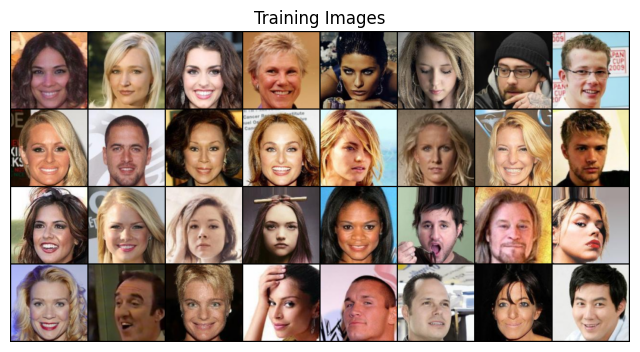

In [4]:
dataset_smaller_network = datasets.CelebA(root=dataroot,
                        split='train',
                        transform=T.Compose([
                               T.CenterCrop(160),
                               T.Resize(image_size_smaller_network),
                               T.ToTensor(),
                           ]),
                        download=True)

dataset_bigger_network = datasets.CelebA(root=dataroot,
                        split='train',
                        transform=T.Compose([
                               T.CenterCrop(160),
                               T.Resize(image_size_bigger_network),
                               T.ToTensor(),
                           ]),
                        download=True)

dataloader_smaller_network = torch.utils.data.DataLoader(dataset_smaller_network, batch_size=batch_size, shuffle=True, num_workers=workers)
dataloader_bigger_network = torch.utils.data.DataLoader(dataset_bigger_network, batch_size=batch_size, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader_bigger_network))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=False).cpu(),(1,2,0)))

In [5]:
generator_smaller_network = Generator(nz, ngf, nc, num_layers_smaller_network).to(device)
discriminator_smaller_network = Discriminator(nc, ndf, num_layers_smaller_network).to(device)

generator_bigger_network = Generator(nz, ngf, nc, num_layers_bigger_network).to(device)
discriminator_bigger_network = Discriminator(nc, ndf, num_layers_bigger_network).to(device)

fixed_noise = torch.load('fixed_noise.t').to(device)

In [6]:
image_list_smaller = train_model(generator_smaller_network, discriminator_smaller_network, num_epochs, lr, dataloader_smaller_network, nz, fixed_noise, "smaller_network_training_progress",  save_every=500, device=device)
image_list_smaller += train_model(generator_smaller_network, discriminator_smaller_network, num_epochs, lr / 5, dataloader_smaller_network, nz, fixed_noise, "smaller_network_training_progress",  save_every=500, device=device)

image_list_bigger = train_model(generator_bigger_network, discriminator_bigger_network, num_epochs, lr, dataloader_bigger_network, nz, fixed_noise, "bigger_network_training_progress",  save_every=500, device=device)
image_list_bigger += train_model(generator_bigger_network, discriminator_bigger_network, num_epochs, lr / 5, dataloader_bigger_network, nz, fixed_noise, "bigger_network_training_progress",  save_every=500, device=device)

In [6]:
# torch.save(generator_smaller_network.state_dict(), model_path_smaller)
# torch.save(generator_bigger_network.state_dict(), model_path_bigger)

In [6]:
generator_smaller_network.load_state_dict(torch.load(model_path_smaller))
generator_bigger_network.load_state_dict(torch.load(model_path_bigger))
generator_smaller_network.eval()
generator_bigger_network.eval();

In [7]:
def display_images(images):
    """
    Display images with a slider.
    
    Parameters:
    - images: A list of numpy ndarrays representing the images.
    """
    
    def view_image(index):
        plt.imshow(images[index]) # Assuming the images are in grayscale
        plt.axis('off') # Hide axes
        plt.show()
    
    # Slider
    widgets.interact(view_image, index=widgets.IntSlider(min=0, max=len(images)-1, step=1, value=0))

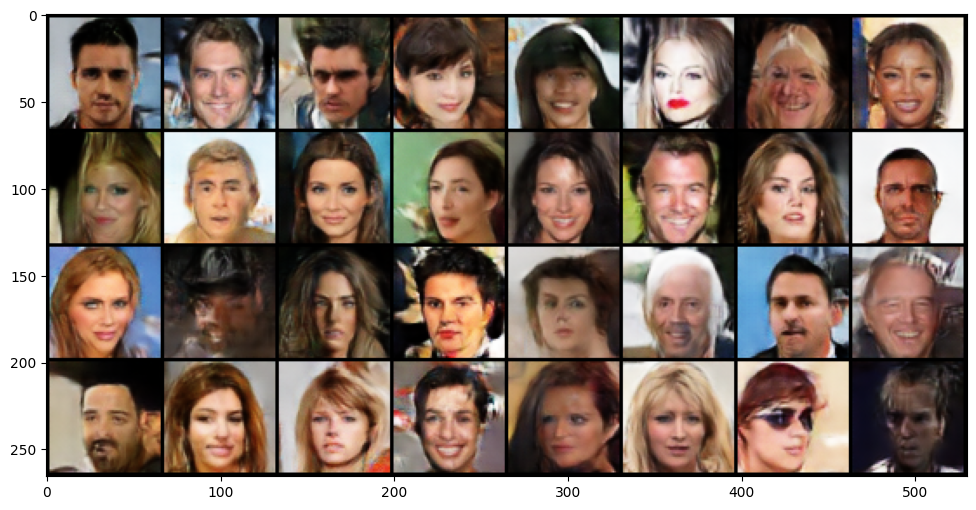

In [8]:
final_fake_images = generator_smaller_network(fixed_noise).cpu().detach()
plt.imshow(msa_utils.convert_to_image_grid(final_fake_images))

In [81]:
smiling_examples_smaller_network = [1, 4, 7, 12, 13, 23, 27]

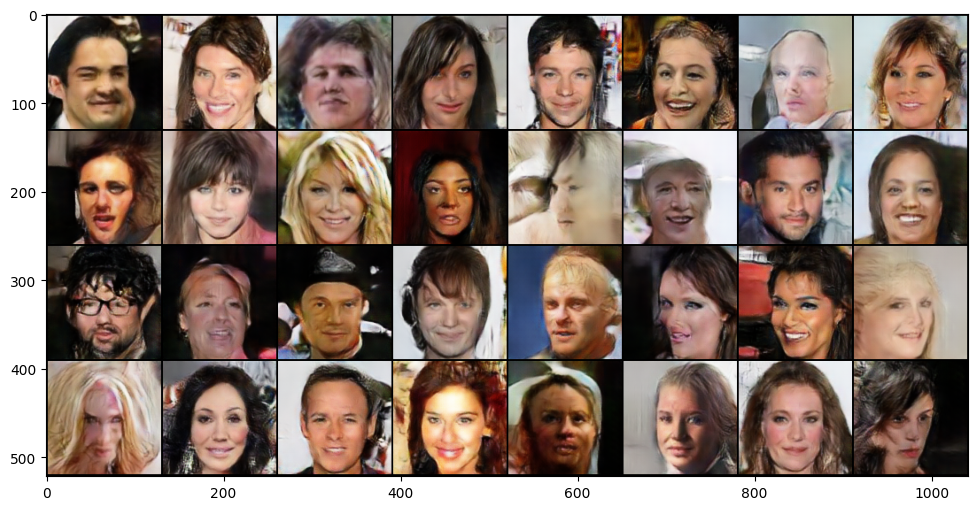

In [9]:
final_fake_images = generator_bigger_network(fixed_noise).cpu().detach()
plt.imshow(msa_utils.convert_to_image_grid(final_fake_images))

In [80]:
smiling_examples_bigger_network = [1, 7, 15, 22, 26]
glasses_example_bigger_network = [16]

In [10]:
def get_elements(num_layers, ngf):
    elements = [(i, j) for i in range(0, num_layers-1) for j in range(ngf * 2 ** (num_layers -2 - i))]
    elements += [(num_layers - 1, i) for i in range(nc)]
    return elements

elements_smaller_network = get_elements(num_layers_smaller_network, ngf)
elements_bigger_network = get_elements(num_layers_bigger_network, ngf)

In [10]:
shapley_modes_smaller_network = msa.interface(
    elements=elements_smaller_network,
    n_permutations=num_permutations_smaller, 
    objective_function=partial(msa_utils.objective_function, generator=generator_smaller_network, fixed_noise=fixed_noise),
    rng=RNG)

shapley_modes_bigger_network = msa.interface(
    elements=elements_bigger_network,
    n_permutations=num_permutations_bigger, 
    objective_function=partial(msa_utils.objective_function, generator=generator_bigger_network, fixed_noise=fixed_noise),
    rng=RNG)

In [12]:
# shapley_modes_smaller_network.to_pickle(shapley_modes_path_smaller)
# shapley_modes_bigger_network.to_pickle(shapley_modes_path_bigger)

In [11]:
with open(shapley_modes_path_smaller, 'rb') as f:
    shapley_modes_smaller_network = pkl.load(f)

with open(shapley_modes_path_bigger, 'rb') as f:
    shapley_modes_bigger_network = pkl.load(f)

In [12]:
layer = 0

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes_smaller_network)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=511), Output()), _dom_classes=('widget-inter…

In [13]:
layer = 0

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes_bigger_network)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=1023), Output()), _dom_classes=('widget-inte…

In [14]:
layer = 2

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes_smaller_network)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=127), Output()), _dom_classes=('widget-inter…

In [15]:
layer = 2

ims = [msa_utils.convert_to_image_grid(layer_contrib) for layer_contrib in msa_utils.get_layer_contributions(layer, shapley_modes_bigger_network)]
display_images(ims)

interactive(children=(IntSlider(value=0, description='index', max=255), Output()), _dom_classes=('widget-inter…

In [30]:
from sklearn.cluster import SpectralClustering

torch.manual_seed(SEED)
fixed_noise_test = torch.randn(32, nz, 1, 1).clip(-1, 1).to(device)

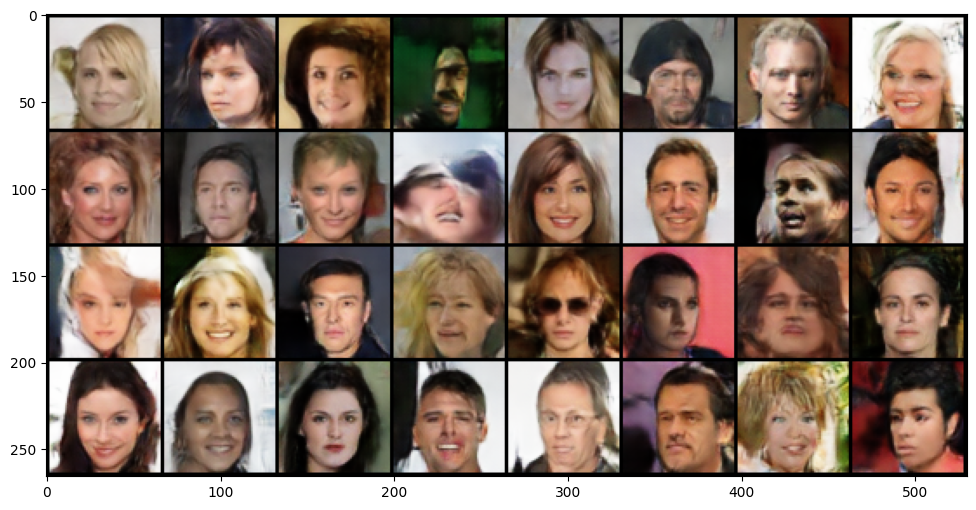

In [31]:
plt.imshow(msa_utils.convert_to_image_grid(generator_smaller_network(fixed_noise_test).cpu().detach()))

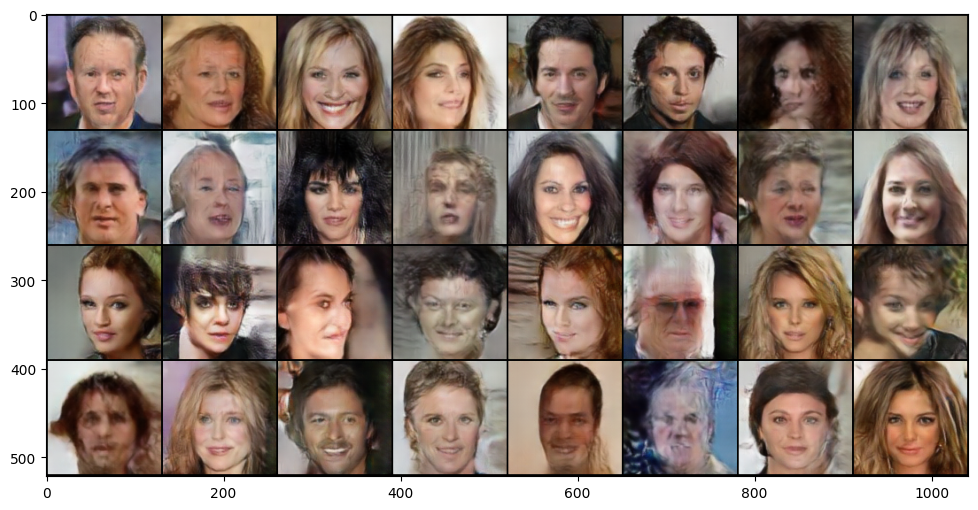

In [35]:
plt.imshow(msa_utils.convert_to_image_grid(generator_bigger_network(fixed_noise_test).cpu().detach()))

In [112]:
spect_clutering_model = SpectralClustering(n_clusters=25, affinity='nearest_neighbors', random_state=SEED, n_init=40)

labels_smaller_network = msa_utils.cluster_modes(shapley_modes_smaller_network, spect_clutering_model.fit_predict, layer_indices=list(range(4)))

In [114]:
all_cluster_contribs = msa_utils.get_all_cluster_contributions(elements_smaller_network, labels_smaller_network, generator_smaller_network, fixed_noise_test)

display_images(all_cluster_contribs)

interactive(children=(IntSlider(value=0, description='index', max=24), Output()), _dom_classes=('widget-intera…

In [113]:
hair_background_cluster_smaller_network = [6]
hair_background_neurons_smaller_network = msa_utils.get_elements_in_cluster(elements_smaller_network, labels_smaller_network, hair_background_cluster_smaller_network)
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_smaller_network, labels_smaller_network, hair_background_cluster_smaller_network, generator_smaller_network, fixed_noise_test)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [71]:
eye_brows_cluster_smaller_network = [18]
eye_brows_neurons_smaller_network = msa_utils.get_elements_in_cluster(elements_smaller_network, labels_smaller_network, eye_brows_cluster_smaller_network)
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_smaller_network, labels_smaller_network, eye_brows_cluster_smaller_network, generator_smaller_network, fixed_noise_test)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [82]:
spect_clutering_model = SpectralClustering(n_clusters=20, affinity='nearest_neighbors', random_state=SEED, n_init=40)

labels_smaller_network = msa_utils.cluster_modes(shapley_modes_smaller_network, spect_clutering_model.fit_predict, smiling_examples_smaller_network, layer_indices=list(range(4)))

In [95]:
blond_hair_cluster_smaller_network = [3, 11]
blond_hair_neurons_smaller_network = msa_utils.get_elements_in_cluster(elements_smaller_network, labels_smaller_network, blond_hair_cluster_smaller_network)
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_smaller_network, labels_smaller_network, blond_hair_cluster_smaller_network, generator_smaller_network, fixed_noise_test)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [121]:
spect_clutering_model = SpectralClustering(n_clusters=30, affinity='nearest_neighbors', random_state=SEED, n_init=40)

labels_bigger_network = msa_utils.cluster_modes(shapley_modes_bigger_network, spect_clutering_model.fit_predict, layer_indices=list(range(5)))

In [26]:
wes_anderson_cluster_bigger_network = [1]
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_bigger_network, labels_bigger_network, wes_anderson_cluster_bigger_network, generator_bigger_network, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [27]:
sclera_cluster_bigger_network = [7]
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_bigger_network, labels_bigger_network, sclera_cluster_bigger_network, generator_bigger_network, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [45]:
smile_example_bigger_network = [1, 7, 15, 26]
spect_clutering_model = SpectralClustering(n_clusters=15, affinity='nearest_neighbors', random_state=SEED, n_init=40)

labels_bigger_network = msa_utils.cluster_modes(shapley_modes_bigger_network, spect_clutering_model.fit_predict, smile_example_bigger_network, layer_indices=list(range(2)))

In [52]:
blond_hair_cluster_bigger_network = [4]
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_bigger_network, labels_bigger_network, blond_hair_cluster_bigger_network, generator_bigger_network, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [63]:
spect_clutering_model = SpectralClustering(n_clusters=30, affinity='nearest_neighbors', random_state=SEED, n_init=40)

labels_bigger_network = msa_utils.cluster_modes(shapley_modes_bigger_network, spect_clutering_model.fit_predict, layer_indices=list(range(2)))

In [77]:
bangs_cluster_bigger_network = [6, 8]
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_bigger_network, labels_bigger_network, bangs_cluster_bigger_network, generator_bigger_network, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [101]:
bangs_cluster_bigger_network = [29]
lesioned_image, unlesioned_image, difference = msa_utils.get_lesioned_output(elements_bigger_network, labels_bigger_network, bangs_cluster_bigger_network, generator_bigger_network, fixed_noise,)

display_images([lesioned_image, unlesioned_image, difference])

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…